# <center><font color=blue>Fuzzy C means Clustering </font>

<font size=4>Use the data provided in the file “clustering_assignmentData.csv” where we know that there are three clusters from the labels (K = 3). Apply Fuzzy C-means algorithm on the data provied where each row in the file corresponds to one data point. <br> <br>

Important Notes:  <br>One important aspect of fuzzy c means that changes the results significantly is the initialization. So you should run the fuzzy c-means algorithm with the given initialization below above 100 times. The final output of the clustering is the result that gives the minimum  J ( the objective function in lec 6 slide 13).
One possible startegy for intialization cluster centers is to select the furthest points from each other. 
it's required to try clustering with different q (the fuzziness Index and visualize the results)
</font>


# <font color=blue> Deliverables: </font>

<font size=4>
• This file after including your code <br>
• A plot of the points provided in the dataset after clustering showing the three identified clusters. For this plot, use the best clustering result out of 100 trials you did and for different q”. </font>

# <font color=blue> Deadline: </font>

<font size=4>•Jan 23, 2021<br>
• Delay Policy: Each day of delay cost you 2 grades and after three days of delay you lose full
assignment grade <br>
• Submissions will be through moodle not by email <br>
• Individual submissions, no teams <br> </font>

# <center><font color=blue>Solution </font>

<font color=blue size=4>1-Needed Packages

In [11]:
import numpy as np
import matplotlib.pylab as plt
import math
import pandas as pd
from numpy.random import seed
import sys
ep = sys.float_info.epsilon
from scipy.spatial import distance

<font color=blue size=4>2-Load Data

In [12]:
def Random_Select(data):
    """
    This Function should implement step 1 in slide 15, Lec 6
    Input: Dataset
    Return: 3-means
    """
    #1. Choose First Center randomly 
    m1=data[np.random.randint(len(data))-1,:]
    dist=(np.sum((data-m1)**2,axis=1))**0.5
    #2. select the second one 
    m2=data[np.argmax(dist),:]
    #3. select the third one 
    dist[np.argmax(dist)]=0
    m3=data[np.argmax(dist),:]
    
    return m1,m2,m3 

In [13]:
def Membership(data,m1,m2,m3, q):
    """
    This function should implement step 2 in slide 15, Lec 6
    Possible values for rnk will be any value between [0,1] 
    Input: Dataset, 3-means, memership matrix, and the fuzziness Index
    Return: New membership matrix with shape (len(data), 3)
    ** hint: the distace between the cluster mean point and itself is zero,
        it will result NANs and INFs in the rnk equation, 
        you can add epsilon to the distaces in you rnk computaions
    """
    rnk = np.zeros((len(data),3))
    rnk_final = np.zeros((len(data),3))
    d = 3
    for i in range(len(data)):
        denoSumTest = 0
        dist1 = distance.euclidean(data[i,:],m1)
        dist2 = distance.euclidean(data[i,:],m2)
        dist3 = distance.euclidean(data[i,:],m3)
        if dist1 == 0 :
            dist1 += ep
        elif dist2 == 0:
            dist2 += ep
        elif dist3 == 0:
            dist3 += ep
        denoSumTest += np.power(1/dist1,1 / (q-1))
        denoSumTest += np.power(1/dist2,1 / (q-1))
        denoSumTest += np.power(1/dist3,1 / (q-1))
        w1 = np.power((1 / dist1), 1 / (q - 1)) / denoSumTest
        w2 = np.power((1 / dist2), 1 / (q - 1)) / denoSumTest
        w3 = np.power((1 / dist3), 1 / (q - 1)) / denoSumTest
        
        rnk[i][0] = w1
        rnk[i][1] = w2
        rnk[i][2] = w3
      
    assert rnk.shape == (len(data), 3)

    return rnk


In [14]:
def Update_Means(data,rnk,q):
    """
    This function should implement step 3 in slide 15, Lec 6
    
    Input: Dataset, memership vector, and the fuzzines index
    Return: updated 3-means
    """
    n=len(data)
    rn1pq=(rnk[:,0]**q).reshape((n,1))
    m1=np.sum(rn1pq*data,axis=0)/np.sum(rn1pq,axis=0)
    rn2pq=(rnk[:,1]**q).reshape((n,1))
    m2=np.sum(rn2pq*data,axis=0)/np.sum(rn2pq,axis=0)
    rn3pq=(rnk[:,2]**q).reshape((n,1))
    m3=np.sum(rn3pq*data,axis=0)/np.sum(rn3pq,axis=0)
    return m1,m2,m3

In [15]:
def Objective_Function(data,rnk,m1,m2,m3, q):
    """
    This function should implement  objective Function in slide 13,Lec 6
    
    Input: Dataset, memership matrix, 3-means, and the fuzzines index
    Return: Total Average Distance
    """

    Avgdist = 0
    num_of_data_points = len(data)
    num_of_classes = 3
    means = np.array ( [ m1 , m2 , m3 ] )
    for i in range ( num_of_data_points ) :
        for j in range ( num_of_classes ) :
            Avgdist += (rnk [ i , j ] ** q) * np.sum ( (data [ i , : ] - means [ j ]) ** 2 )

    return Avgdist

In [16]:
def Stopping_Criteria(m1_b,m2_b,m3_b,m1,m2,m3):
    """
    This function should Test Convergence
    
    Input:  3-means before updating and after it.
    Return: return True or  return False
    ** hint: unlike this step in the k means algorithm,
            you need to compute the differnce between the old and new means,
            and comapre the difference to a very small threshold, 
            or your can compare after rounding the means to 4 of 5 decimal places.
    """
    if (round(np.array_equal(m1,m1_b)),4)  and (round(np.array_equal(m2,m2_b)),4) and (round(np.array_equal(m3,m3_b)),4):
        return True
    else:
        return False


In [17]:
#________________________Main Code Statrs here___________________________________
def myFCM(data, q):
        assert q > 1
        m1f,m2f,m3f=np.zeros((2,100)),np.zeros((2,100)),np.zeros((2,100)) # 3 - Means 

        Avgdist=np.zeros((100,))
        counter=0

        while(counter <100):
            
                # --------------------Intialization Step 1------------------------------#
                seed(counter)
                m1,m2,m3 = Random_Select(data)

                rnk = np.zeros(len(data)) # Membership Vector

                m1_b = m1
                m2_b = m2
                m3_b = m3
                cc = 0
                while(True):
                    #---------------Step 2 compute rnk-----------------------------------------#

                    rnk = Membership(data,m1,m2,m3, q)

                    assert all(np.round(np.sum(rnk, axis = 1), 2) == np.ones(len(rnk)))

                    #---------------Step 3 update means-----------------------------------------#

                    m1,m2,m3 = Update_Means(data,rnk, q)

                    #---------------Step 4 Test Convergence -----------------------------------------#

                    if Stopping_Criteria(m1_b,m2_b,m3_b,m1,m2,m3):
                         m1f[:,counter],m2f[:,counter],m3f[:,counter] = m1,m2,m3

                         Avgdist[counter] = Objective_Function(data,rnk,m1,m2,m3, q)
                         break


                    m1_b = m1
                    m2_b = m2
                    m3_b = m3

                counter += 1     

        idx = np.argmin(Avgdist)
        m1_ = m1f[:,idx]
        m2_ = m2f[:,idx]
        m3_ = m3f[:,idx]
        rnk_=np.argmax(Membership(data,m1_,m2_,m3_, q), axis = 1)
        return rnk_, m1_, m2_, m3_

In [18]:
# Load Data
df = pd.read_csv('clustering_assignmentData.csv')
data = df[['X1', 'X2']].values
y = df['y'].values

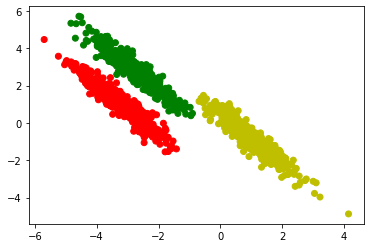

In [19]:
plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), y)))

# Plotting 

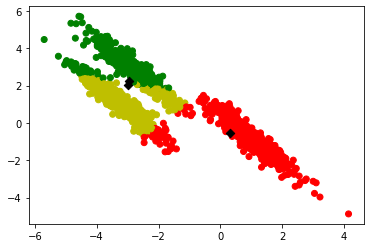

In [20]:
# Plotting the Final Centroids and data. 
q  =2
rnk_ , m1_, m2_, m3_= myFCM(data, q)
plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), rnk_)))
plt.scatter([m1_[0], m2_[0],m3_[0]],[m1_[1], m2_[1], m3_[1]], marker = 'D', c = 'black')


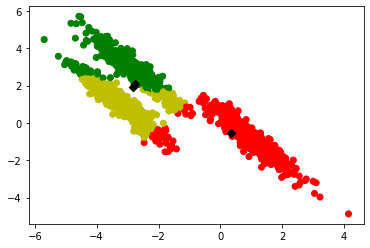

In [21]:
q = 3
rnk_ , m1_, m2_, m3_= myFCM(data, q)

plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), rnk_)))
plt.scatter([m1_[0], m2_[0],m3_[0]],[m1_[1], m2_[1], m3_[1]], marker = 'D', c = 'black')

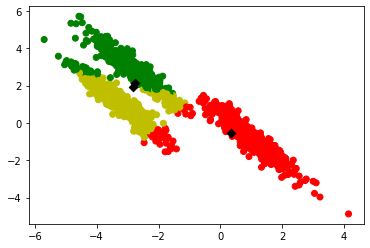

In [22]:
q = 4
rnk_ , m1_, m2_, m3_= myFCM(data, q)

plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), rnk_)))
plt.scatter([m1_[0], m2_[0],m3_[0]],[m1_[1], m2_[1], m3_[1]], marker = 'D', c = 'black')

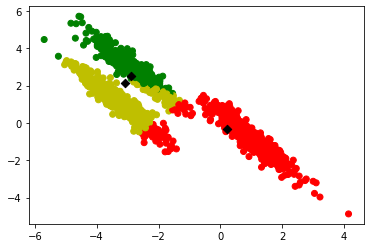

In [23]:
q = 5
rnk_ , m1_, m2_, m3_= myFCM(data, q)

plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), rnk_)))
plt.scatter([m1_[0], m2_[0],m3_[0]],[m1_[1], m2_[1], m3_[1]], marker = 'D', c = 'black')